In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt

def entropy(v,num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h+(freq[i]/num)*np.log2(freq[i]/num)
    h = -h
    return h


def entropy_for_files(v,num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int.from_bytes(bytes(v[i], 'latin-1'), byteorder="big")]=freq[int.from_bytes(bytes(v[i], 'latin-1'), byteorder="big")]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h+(freq[i]/num)*np.log2(freq[i]/num)
    h = -h
    return h

def diff_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file,8*i)
    return h_vector

def diff_analysis_for_files(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy_for_files(file,8*i)
    return h_vector

def diff_area(h_1,h_2):
    area = 0
    diff_vec = np.zeros(len(h_1))
    for i in range(len(h_1)):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,len(h_1)-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

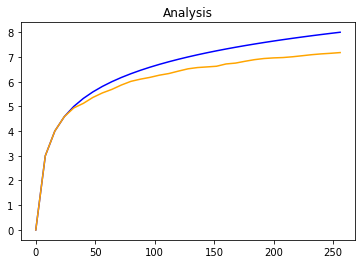

In [7]:
ideal_file = np.zeros(256)
for i in range(len(ideal_file)):
    ideal_file[i]=i
    
fileprova1 = np.zeros(1024)
for i in range(len(fileprova1)):
    fileprova1[i]=randint(0,255)

fileprova2 = np.zeros(1024)
for i in range(len(fileprova2)):
    fileprova2[i]=randint(0,255)

header_length = 256
    
x = np.zeros(int(header_length/8)+1)
for i in range(int(header_length/8)+1):
    x[i]= 8*i

h_ideal = diff_analysis(ideal_file, header_length)
h1 = diff_analysis(fileprova1, header_length)
h2 = diff_analysis(fileprova2, header_length)
    
plt.title("Analysis")
plt.plot(x, h_ideal, color="blue")
plt.plot(x, h2, color="orange")

plt.show()

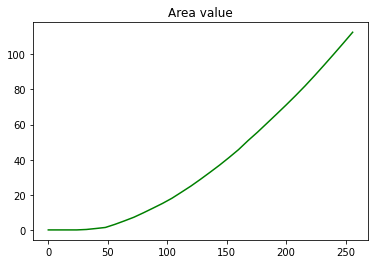

In [8]:
area = np.zeros(33)
for i in range(8,257,8):
    header_length = i
    h_ideal = diff_analysis(ideal_file, header_length)
    h1 = diff_analysis(fileprova1, header_length)
    h2 = diff_analysis(fileprova2, header_length)
    area[int(i/8)] = diff_area(h_ideal,h2)

plt.title("Area value")
plt.plot(x, area, color="green")

plt.show()

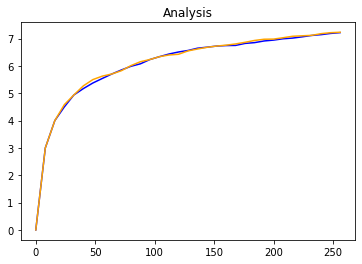

In [2]:
f = open("./Dharma_dataset/0001-doc.doc.id-0481FA80.[paymentbtc@firemail.cc].cmb", "r", encoding='latin-1')
file=f.read()

header_length = 256
    
x = np.zeros(int(header_length/8)+1)
for i in range(int(header_length/8)+1):
    x[i]= 8*i

h = diff_analysis_for_files(file, header_length)

fileprova1 = np.zeros(1024)
for i in range(len(fileprova1)):
    fileprova1[i]=randint(0,255)

h1 = diff_analysis(fileprova1, header_length)
    
plt.title("Analysis")
plt.plot(x, h, color="blue")
plt.plot(x, h1, color="orange")

plt.show()

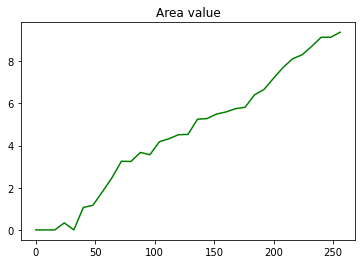

In [3]:
area = np.zeros(33)
for i in range(8,257,8):
    header_length = i
    h = diff_analysis_for_files(file, header_length)
    h1 = diff_analysis(fileprova1, header_length)
    area[int(i/8)] = diff_area(h,h1)

plt.title("Area value")
plt.plot(x, area, color="green")

plt.show()